Tenemos un dataset con datos históricos de varias variables promediadas en valores diarios de 6 los últimos 6 años.

Se tiene el siguiente diccionario de datos:
- La columna de índice es la fecha.
- PresionAire: es la presión del aire en milibars
- PresionVapor: es la presión del vapor de agua en el aire en milibars
- Humedadrelativa: es el porcentaje de humedad relativa
- ConcentracionVapor: es la concentración del vapor de agua en mmol/mol
- DensidadAire: es la densidad del aire en g/metros cúbicos
- DireccionViento: es la dirección del viento en grados
- Temperatura: es la temperatura en grados centigrados

In [289]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import math as mt

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso #modelamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [290]:
import sklearn as sk
print(sk.__version__)

0.23.2


In [291]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [292]:
# Imprima 4 filas del inicio y 4 al final
pd.set_option('display.max_rows', 20)

In [293]:
df = pd.read_csv("datos_clima.csv")

In [294]:
# Se verifica la carga
df

,Unnamed: 0,PresionAire (mbar),PresionVapor (mbar),HumedadRelativa (%),ConcentracionVapor (mmol/mol),DensidadAire (g/m**3),DireccionViento (grado),Temperatura (C)
0,01.01.2010,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,02.01.2010,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,03.01.2010,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,04.01.2010,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,05.01.2010,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736
...,...,...,...,...,...,...,...,...
2188,27.12.2015,1002.411250,8.530347,79.140625,8.510764,1237.405625,190.177083,8.167083
2189,28.12.2015,1002.468194,7.347917,91.898611,7.329375,1257.736389,153.824792,3.761111
2190,29.12.2015,1003.816736,7.504514,94.815278,7.478403,1260.613194,187.764653,3.485625
2191,30.12.2015,998.772639,4.638125,67.657431,4.641250,1265.083611,178.779861,1.395694


In [295]:
# se verifican los tipos
df.dtypes

Unnamed: 0                        object
PresionAire (mbar)               float64
PresionVapor (mbar)              float64
HumedadRelativa (%)              float64
ConcentracionVapor (mmol/mol)    float64
DensidadAire (g/m**3)            float64
DireccionViento (grado)          float64
Temperatura (C)                  float64
dtype: object

<h1>Preparación general de los datos

- Renombramiento de columnas
- Conversión de columnas tipos fechas
- Ordenamiento por fechas
- Redondeo de los valores
- Revisión de la calidad de los datos

In [296]:
df.columns = ['Fecha', 'P.Aire', 'P.Vapor', 'Hum.Rel', 'C.Vapor', 'D.Aire', 'D.Vapor', 'Temp']

In [297]:
# se cambia el tipo de la columna 0 a Date
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y');
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    2193 non-null   datetime64[ns]
 1   P.Aire   2193 non-null   float64       
 2   P.Vapor  2193 non-null   float64       
 3   Hum.Rel  2193 non-null   float64       
 4   C.Vapor  2193 non-null   float64       
 5   D.Aire   2193 non-null   float64       
 6   D.Vapor  2193 non-null   float64       
 7   Temp     2193 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 137.2 KB


In [298]:
# Ordenamiento del dataframe
df.sort_values(by=['Fecha'])

,Fecha,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp
0,2010-01-01,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,2010-01-02,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,2010-01-03,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,2010-01-04,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,2010-01-05,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736
...,...,...,...,...,...,...,...,...
2188,2015-12-27,1002.411250,8.530347,79.140625,8.510764,1237.405625,190.177083,8.167083
2189,2015-12-28,1002.468194,7.347917,91.898611,7.329375,1257.736389,153.824792,3.761111
2190,2015-12-29,1003.816736,7.504514,94.815278,7.478403,1260.613194,187.764653,3.485625
2191,2015-12-30,998.772639,4.638125,67.657431,4.641250,1265.083611,178.779861,1.395694


In [299]:
# test = pd.concat([df, 'Temp2'=df.iloc[1:,len(df.columns)-1:]])
# test.head()
target = df.iloc[3:,len(df.columns)-1:]
# target.reset_index(drop=True, inplace=True)
target.head()

prueba = df.copy()
prueba['Temp2'] = target
prueba.head()

,Fecha,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp,Temp2
0,2010-01-01,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403,NaN
1,2010-01-02,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667,NaN
2,2010-01-03,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903,NaN
3,2010-01-04,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306,-6.284306
4,2010-01-05,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736,-10.286736


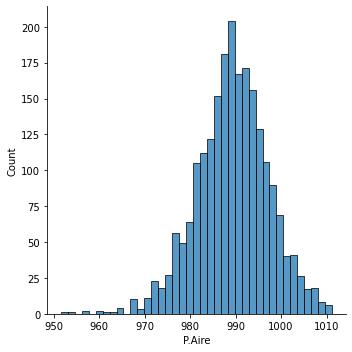

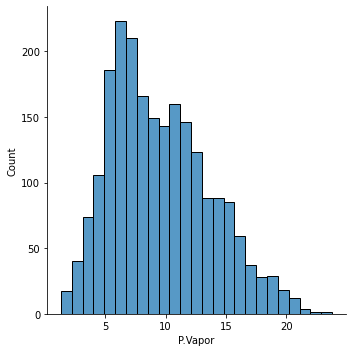

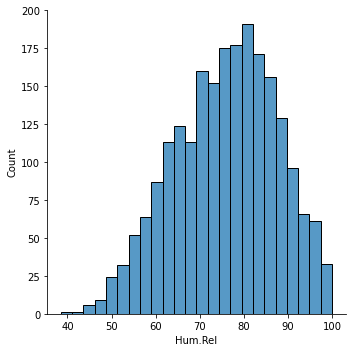

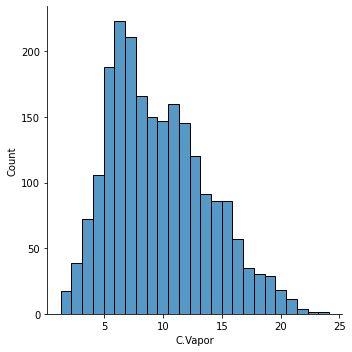

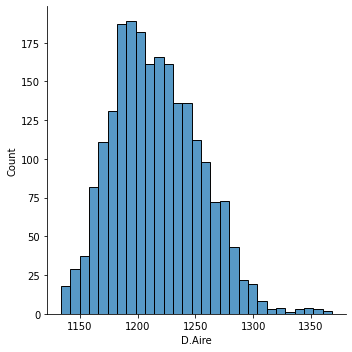

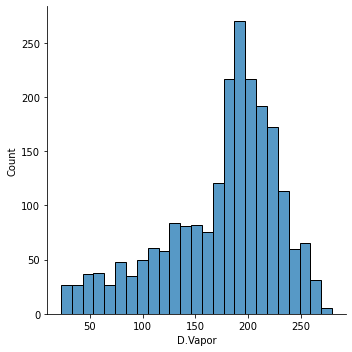

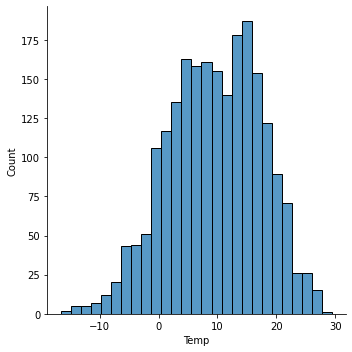

In [300]:
import matplotlib.pyplot as plt
for col in df.columns[1:]:
    df[col] = df[col].round(decimals=2) # Redondeo de los valores a 0 decimales
    # df[col] = df[col].astype(int)       # Las predicciones no reciben float
    sns.displot(df, x=col)

In [301]:
df.describe()

,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,989.291952,9.528664,75.839558,9.635121,1216.120219,174.249950,9.462321
std,7.913174,4.106531,11.592708,4.157923,37.622388,54.484004,7.861140
min,951.560000,1.300000,38.500000,1.290000,1133.430000,22.570000,-16.580000
25%,984.380000,6.280000,67.520000,6.340000,1188.260000,141.960000,3.900000
50%,989.460000,8.910000,76.750000,8.980000,1212.650000,187.760000,9.720000
75%,994.390000,12.230000,84.440000,12.360000,1242.080000,211.460000,15.360000
max,1011.200000,23.800000,100.000000,24.120000,1368.360000,279.370000,29.450000


Se busca ahora comenzar a generar el corte transversal, haciendo variables promedio: 

# Parte 1: Modelos shallow (3 puntos)

Utilizando modelos shallow (por oposición a profundos), desarrolle modelos predictivos que permitan predecir la temperatura del séptimo día siguiente:

- No utilice modelos de forecasting como ARIMA o Holt-Winters
- Establezca variables a partir de los datos históricos. Por ejemplo, puede establecer datos como la temperatura promedio de los últimos 3 días, de los últimos 7 días, de los últimos 10 días, la presión del aire mínima de los últimos 3 días, de los últimos 7 días, de los últimos 15 días, los valores del día anterior de todas las variables, lo valores de hace 1 año en la misma fecha, etc.
- Debe crear un dataset de corte transversal, estimando las variables a utilizar cada día, o cada semana, o cada mes.
- Utilice modelos como SVM y redes neuronales artificiales tradicionales
- Utilice técnicas de seleccion de variables como PCA, LDA y Lasso
- Intente aplicar diferentes técnicas de normalización

<h1>1.1 Creación de los data sets

## 1.1.1 Creación del data frame de corte transversal

Para la creación del Dataframe de corte transversal se tendran en cuenta periodos de 7 y 15 días, se realizará tambien una asignación basada en medidas estadísticas básicas, máximo, mínimo y promedio.

- Definición de la ventada (7 días anteriores)
- Creación de las variables con base a la ventana para poder usarlo como una base de corte transversal:
    - Prom: Promedio de los últimos valores de la ventana
    - Max: Máximo de los últimos valores de la ventana
    - Min: Mínimo de los últimos valores de la ventana    

In [302]:
# Creamos un nuevo data frame para no modificar el original
df1 = pd.DataFrame()

# ventana = 3
# Generamos las variables de corte transversal
for ventana in [7,15,30]:
    for col in df.columns[1:]:
        prom = df[col].rolling(window=ventana).mean()
        nom_col = col + '.Prom.' + str(ventana) + ' días'
        df1[nom_col] = prom
        max  = df[col].rolling(window=ventana).max()
        nom_col = col + '.Max.' + str(ventana) + ' días'
        df1[nom_col] = max
        min  = df[col].rolling(window=ventana).min()
        nom_col = col + '.Min.' + str(ventana) + ' días'
        df1[nom_col] = min 

# Agregamos la variable dependiente (Temperatura del septimo día)
target = df.iloc[6:,len(df.columns)-1:]
target.reset_index(drop=True, inplace=True)
df1['Temp.Target.7'] = target
# df1 = pd.concat([df1, df['Temp']], axis=1)

df1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 64 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   P.Aire.Prom.7 días    2187 non-null   float64
 1   P.Aire.Max.7 días     2187 non-null   float64
 2   P.Aire.Min.7 días     2187 non-null   float64
 3   P.Vapor.Prom.7 días   2187 non-null   float64
 4   P.Vapor.Max.7 días    2187 non-null   float64
 5   P.Vapor.Min.7 días    2187 non-null   float64
 6   Hum.Rel.Prom.7 días   2187 non-null   float64
 7   Hum.Rel.Max.7 días    2187 non-null   float64
 8   Hum.Rel.Min.7 días    2187 non-null   float64
 9   C.Vapor.Prom.7 días   2187 non-null   float64
 10  C.Vapor.Max.7 días    2187 non-null   float64
 11  C.Vapor.Min.7 días    2187 non-null   float64
 12  D.Aire.Prom.7 días    2187 non-null   float64
 13  D.Aire.Max.7 días     2187 non-null   float64
 14  D.Aire.Min.7 días     2187 non-null   float64
 15  D.Vapor.Prom.7 días  

<h2>1.1.2 Limpieza de datos

In [303]:
df1.head()

,P.Aire.Prom.7 días,P.Aire.Max.7 días,P.Aire.Min.7 días,P.Vapor.Prom.7 días,P.Vapor.Max.7 días,P.Vapor.Min.7 días,Hum.Rel.Prom.7 días,Hum.Rel.Max.7 días,Hum.Rel.Min.7 días,C.Vapor.Prom.7 días,...,D.Aire.Prom.30 días,D.Aire.Max.30 días,D.Aire.Min.30 días,D.Vapor.Prom.30 días,D.Vapor.Max.30 días,D.Vapor.Min.30 días,Temp.Prom.30 días,Temp.Max.30 días,Temp.Min.30 días,Temp.Target.7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.39
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.46
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.28
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.18
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.80


Se realiza el proceso de limpieza a través de la eliminación de registros no válidos.

- Eliminar los registros con variables nulas generados por los primeros N registros menores a la ventana 

In [304]:
df1.dropna(inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2158 entries, 29 to 2186
Data columns (total 64 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   P.Aire.Prom.7 días    2158 non-null   float64
 1   P.Aire.Max.7 días     2158 non-null   float64
 2   P.Aire.Min.7 días     2158 non-null   float64
 3   P.Vapor.Prom.7 días   2158 non-null   float64
 4   P.Vapor.Max.7 días    2158 non-null   float64
 5   P.Vapor.Min.7 días    2158 non-null   float64
 6   Hum.Rel.Prom.7 días   2158 non-null   float64
 7   Hum.Rel.Max.7 días    2158 non-null   float64
 8   Hum.Rel.Min.7 días    2158 non-null   float64
 9   C.Vapor.Prom.7 días   2158 non-null   float64
 10  C.Vapor.Max.7 días    2158 non-null   float64
 11  C.Vapor.Min.7 días    2158 non-null   float64
 12  D.Aire.Prom.7 días    2158 non-null   float64
 13  D.Aire.Max.7 días     2158 non-null   float64
 14  D.Aire.Min.7 días     2158 non-null   float64
 15  D.Vapor.Prom.7 días 

In [305]:
df1.reset_index(drop=True, inplace=True)
df1.head()

,P.Aire.Prom.7 días,P.Aire.Max.7 días,P.Aire.Min.7 días,P.Vapor.Prom.7 días,P.Vapor.Max.7 días,P.Vapor.Min.7 días,Hum.Rel.Prom.7 días,Hum.Rel.Max.7 días,Hum.Rel.Min.7 días,C.Vapor.Prom.7 días,...,D.Aire.Prom.30 días,D.Aire.Max.30 días,D.Aire.Min.30 días,D.Vapor.Prom.30 días,D.Vapor.Max.30 días,D.Vapor.Min.30 días,Temp.Prom.30 días,Temp.Max.30 días,Temp.Min.30 días,Temp.Target.7
0,986.467143,1009.92,960.67,3.432857,4.98,1.95,78.735714,81.5,73.85,3.502857,...,1282.296667,1347.08,1222.7,142.735333,248.07,31.43,-5.013333,2.15,-12.16,-0.71
1,983.214286,1009.92,960.67,3.472857,4.98,1.95,78.887143,81.5,73.85,3.555714,...,1282.703000,1347.08,1222.7,147.014000,248.07,31.43,-5.041000,2.15,-12.16,-0.01
2,980.221429,1009.92,960.67,3.587143,4.98,1.95,78.427143,81.5,73.85,3.680000,...,1281.988333,1347.08,1222.7,146.249667,248.07,31.43,-4.936667,2.15,-12.16,-5.17
3,976.165714,997.00,960.67,3.898571,4.98,2.03,77.612857,81.5,73.85,4.005714,...,1281.145333,1347.08,1222.7,148.896667,248.07,31.43,-4.839333,2.15,-12.16,-7.13
4,973.822857,981.53,960.67,4.310000,4.98,3.45,78.262857,81.5,75.26,4.428571,...,1279.729667,1347.08,1222.7,151.882333,248.07,31.43,-4.618333,2.15,-12.16,-6.81


<h2>1.1.3 Particionamiento de los datos

- Reordenar aleatoriamente los registros del data frame de corte transversal
- Particionar el data frame en 70% entrenamiento y 30% test

In [306]:
# Semilla para poder replicar el ejercicio
random_state = 40

In [307]:
#df1.reset_index(drop=True, inplace=True)

In [308]:
# Proceso Manual
# X_train = df1.iloc[:1530,:]
# X_train = X_train.sample(frac=1, random_state=random_state)
# y_train = X_train['Temp'] 
# X_train = X_train.iloc[:,:len(X_train.columns)-1]
# X_test = df1.iloc[:1530,:]
# y_test = X_test['Temp'] 
# X_test = X_test.iloc[:,:len(X_test.columns)-1]

# Proceso automatizado
X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:len(df1.columns)-1], df1['Temp.Target.7'], train_size=0.7, shuffle=False)

In [309]:
# Verificamos el contenido del set de entrenamiento (independientes)
X_train.head()

,P.Aire.Prom.7 días,P.Aire.Max.7 días,P.Aire.Min.7 días,P.Vapor.Prom.7 días,P.Vapor.Max.7 días,P.Vapor.Min.7 días,Hum.Rel.Prom.7 días,Hum.Rel.Max.7 días,Hum.Rel.Min.7 días,C.Vapor.Prom.7 días,...,C.Vapor.Min.30 días,D.Aire.Prom.30 días,D.Aire.Max.30 días,D.Aire.Min.30 días,D.Vapor.Prom.30 días,D.Vapor.Max.30 días,D.Vapor.Min.30 días,Temp.Prom.30 días,Temp.Max.30 días,Temp.Min.30 días
0,986.467143,1009.92,960.67,3.432857,4.98,1.95,78.735714,81.5,73.85,3.502857,...,1.93,1282.296667,1347.08,1222.7,142.735333,248.07,31.43,-5.013333,2.15,-12.16
1,983.214286,1009.92,960.67,3.472857,4.98,1.95,78.887143,81.5,73.85,3.555714,...,1.93,1282.703000,1347.08,1222.7,147.014000,248.07,31.43,-5.041000,2.15,-12.16
2,980.221429,1009.92,960.67,3.587143,4.98,1.95,78.427143,81.5,73.85,3.680000,...,1.93,1281.988333,1347.08,1222.7,146.249667,248.07,31.43,-4.936667,2.15,-12.16
3,976.165714,997.00,960.67,3.898571,4.98,2.03,77.612857,81.5,73.85,4.005714,...,1.93,1281.145333,1347.08,1222.7,148.896667,248.07,31.43,-4.839333,2.15,-12.16
4,973.822857,981.53,960.67,4.310000,4.98,3.45,78.262857,81.5,75.26,4.428571,...,1.93,1279.729667,1347.08,1222.7,151.882333,248.07,31.43,-4.618333,2.15,-12.16


In [310]:
# Verificamos el contenido del set de entrenamiento (dependiente)
y_train.head()

0   -0.71
1   -0.01
2   -5.17
3   -7.13
4   -6.81
Name: Temp.Target.7, dtype: float64

In [311]:
# Modifica el orden de los datos de prueba pero conservando la relación entre las variable X y la Y
X_train = X_train.sample(frac=1, random_state=random_state)
y_train = y_train.sample(frac=1, random_state=random_state)

In [312]:
print(X_train.iloc[:,:1].head(),'\n')
print(type(y_train))
print(type(X_train))


      P.Aire.Prom.7 días
602           989.665714
1497          981.584286
1021          994.180000
621           987.332857
623           993.340000 

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


<h2> 1.2 Pipelines de entrenamiento y evaluación del mejor modelo

Para seleccionar el mejor modelo se compararán los algoritmos de PCA, LDA y Lasso con base a la métrica <u>r2</u>

Utilizando objetos **Pipeline**, encuentren el mejor modelo **SVC** para el dataset analizado. Haga diferentes intentos, variando:

- el tipo de normalización utilizada (Sin normalización, con **StandardScaler**)
- el tipo de reducción de dimensionalidad (Sin reducción, con **PCA**, con **LDA**), especificando None, 10, 15 y 20 dimensiones
- el tipo de kernel utilizado por un modelo **SVC** (linear, rbf, o sigmoid). El kernel poly, al tener 26 variables no es una opción viable.
- el valor del parámetro *C*
- el valor del parámetro *gamma* cuando aplique

Trabaje sobre el 70% de los datos, particionados de manera estratificada según la variable objetivo.

Utilice 'r2', como medida de evaluación de la calidad del ajuste de los modelos, usando el protocolo de evaluación de cross-validation con 5 folds.

Compare las curvas ROC AUC de los 2 mejores clasificadores encontrados.

In [313]:
metrica = "r2"

<h2>1.2.1 Modelos

(A) Modelo con el siguiente pipeline:

- Sin Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel linear

Se monta sobre un grid de búsqueda con parámetros para SVR(linear).

In [288]:
steps = [("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}

grid2 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid2.fit(X_train,y_train)  
print("score = %3.4f" %(grid2.score(X_test,y_test)))
print(grid1.best_params_)

train_score2 = grid2.score(X_train, y_train)
test_score2 = grid2.score(X_test, y_test)
print ( "train: ", train_score2 , "test", test_score2)

KeyboardInterrupt: 

(B) Modelo con el siguiente pipeline:

- Sin Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para SVR(rbf).

In [58]:
steps = [("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}

grid3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid3.fit(X_train,y_train)  
print("score = %3.4f" %(grid3.score(X_test,y_test)))
print(grid1.best_params_)

train_score3 = grid3.score(X_train, y_train)
test_score3 = grid3.score(X_test, y_test)
print ( "train: ", train_score3 , "test", test_score3)

score = -0.1185
{'PCA__n_components': None, 'SVM_rbf__C': 10}
train:  0.951997947953693 test -0.11850704916362487


(C) Modelo con el siguiente pipeline:

- Sin Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel sigmoid
- Se monta sobre un grid de búsqueda con parámetros para SVR(sigmoid) / C + Gamma.

In [60]:
steps = [("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}

grid4 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid4.fit(X_train,y_train)  
print("score = %3.4f" %(grid4.score(X_test,y_test)))
print(grid1.best_params_)

train_score4 = grid4.score(X_train, y_train)
test_score4 = grid4.score(X_test, y_test)
print ( "train: ", train_score3 , "test", test_score4)

score = -0.1210
{'PCA__n_components': None, 'SVM_rbf__C': 10}
train:  0.951997947953693 test -0.1210235989516597


De los modelos probados, el mejor resultado está en el pipeline del modelo (B) (Sin Estandarización, Máquina de vector de soporte para regresión (SVR) con kernel linear). Los valores obtenbidos durante la evaluación fueron:

train:  0.7369 / test 0.5617

# Modelos con estandarización de los datos:

(A1) Modelo con el siguiente pipeline:

- Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel linear

Se monta sobre un grid de búsqueda con parámetros para SVR(linear).

In [62]:
steps = [('STD', StandardScaler()), ("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}

grid5 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid5.fit(X_train, y_train)
print("score = %3.4f" %(grid5.score(X_test,y_test)))
print(grid5.best_params_)

train_score5 = grid5.score(X_train, y_train)
test_score5 = grid5.score(X_test, y_test)
print ( "train: ", train_score5 , "test", test_score5)

score = 0.5297
{'SVM_linear__C': 10}
train:  0.740328535971642 test 0.5297040003170035


(A2) Modelo con el siguiente pipeline:

- Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para el SVR(rbf) - C / Gamma

In [65]:
steps = [('STD', StandardScaler()),("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}

grid6 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid6.fit(X_train, y_train)
print("score = %3.4f" %(grid6.score(X_test,y_test)))
print(grid6.best_params_)

train_score6 = grid6.score(X_train, y_train)
test_score6 = grid6.score(X_test, y_test)
print ( "train: ", train_score6 , "test", test_score6)

score = 0.5203
{'SVM_rbf__C': 10, 'SVM_rbf__gamma': 0.05}
train:  0.9700754392432781 test 0.5203424483858672


(A3) Modelo con el siguiente pipeline:

-Estandarización

-Máquina de vector de soporte para regresión (SVR) con kernel sigmoide

-Se monta sobre un grid de búsqueda con parámetros para el SVR(rbf) - C / Gamma

In [64]:
steps = [('STD', StandardScaler()), ("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}

grid7 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid7.fit(X_train, y_train)
print("score = %3.4f" %(grid7.score(X_test,y_test)))
print(grid7.best_params_)

train_score7 = grid7.score(X_train, y_train)
test_score7 = grid7.score(X_test, y_test)
print ( "train: ", train_score7 , "test", test_score7)
#Overfitting (yet)

score = 0.6383
{'SVM_sigmoid__C': 0.1, 'SVM_sigmoid__gamma': 0.01}
train:  0.6778519475954159 test 0.6382590485124491


Los modelos evaluados con estandarización, mostraron ser más robustos que aquellos sin estandarización, con resultados más consistentes. El mejor modelo de esta etapa fue el (A3) con pipeline (Estandarización, 
Máquina de vector de soporte para regresión (SVR) con kernel sigmoide, Se monta sobre un grid de búsqueda con parámetros para el SVR(rbf) - C / Gamma).

Se destaca que los valores obtenidos, muestran una mejor diferencia entre los conjuntos de entrenamiento y prueba,dando indicios de no overfitting

train:  0.6779 / test 0.6383

## Modelos con estandarización de los datos y PCA:

(B1) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(rbf) solo con C

In [66]:
steps = [('STD', StandardScaler()),
         ('PCA', PCA()),
         ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)         
parametros = {'PCA__n_components':[None, 10, 15, 20], 'SVM_rbf__C':[0.01,0.1,1,10]}  

grid0 = GridSearchCV(pipeline, parametros, cv=5, scoring="r2") 
grid0.fit(X_train,y_train)     
print("score = %3.4f" %(grid0.score(X_test,y_test)))
print(grid1.best_params_)

train_score0 = grid0.score(X_train, y_train)
test_score0 = grid0.score(X_test, y_test)
print ( "train: ", train_score1 , "test", test_score1)
# Los valores obtenidos muestran incidencia de Overfitting en el modelo con una diferencia elevada entre el test y el train.

score = 0.5664
{'PCA__n_components': None, 'SVM_rbf__C': 10}
train:  0.9082409952006731 test 0.5663606619118159


In [ ]:
(B2) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel linear

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(linear).

In [68]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10], 'PCA__n_components':[None, 5, 10, 15, 20]}

grid8 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid8.fit(X_train, y_train)
print("score = %3.4f" %(grid8.score(X_test,y_test)))
print(grid8.best_params_)

train_score8 = grid8.score(X_train, y_train)
test_score8 = grid8.score(X_test, y_test)
print ( "train: ", train_score8 , "test", test_score8)

score = 0.5297
{'PCA__n_components': None, 'SVM_linear__C': 10}
train:  0.7403285359717062 test 0.5297040003170521


(B3) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(linear), con C y Gamma

In [71]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10, 20], 'SVM_rbf__gamma':[0.05,0.01, 1, 5, 10], 'PCA__n_components':[None, 10, 15, 20]}

grid9 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid9.fit(X_train, y_train)
print("score = %3.4f" %(grid9.score(X_test,y_test)))
print(grid9.best_params_)

train_score9 = grid9.score(X_train, y_train)
test_score9 = grid9.score(X_test, y_test)
print ( "train: ", train_score9 , "test", test_score9)

score = 0.4984
{'PCA__n_components': None, 'SVM_rbf__C': 20, 'SVM_rbf__gamma': 0.05}
train:  0.9824531053985184 test 0.4984006851244952


(B4) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel sigmoide

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(linear), con C y Gamma

In [72]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5], 'PCA__n_components':[None, 10, 15, 20]}

grid10 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid10.fit(X_train, y_train)
print("score = %3.4f" %(grid10.score(X_test,y_test)))
print(grid10.best_params_)

train_score10 = grid10.score(X_train, y_train)
test_score10 = grid10.score(X_test, y_test)
print ( "train: ", train_score10 , "test", test_score10)

score = 0.6383
{'PCA__n_components': None, 'SVM_sigmoid__C': 0.1, 'SVM_sigmoid__gamma': 0.01}
train:  0.677851947595416 test 0.6382590485124492


Tras evaluar diferentes modelos asociados a la utilización de PCA más estadarización, se obtiene que el mejor modelo continúa siendo el (A3) de la sección previa, con un resultado de comparación de:

train:  0.6779 / test 0.6383

En la presente sección, los modelos (B) mostraron altos grados en Overfitting.

In [76]:
# Resultados con SVR tras difentes procesos de reducción de dimensionalidad y estandarización.

print ( "Grid1 "+"\t train: ", train_score0 , "\t test", test_score0)
print ( "Grid1 "+"\t train: ", train_score1 , "\t test", test_score1)
print ( "Grid2 "+"\t train: ", train_score2 , "\t test", test_score2)
print ( "Grid3 "+"\t train: ", train_score3 , "\t test", test_score3)
print ( "Grid4 "+"\t train: ", train_score4 , "\t test", test_score4)
print ( "Grid5 "+"\t train: ", train_score5 , "\t test", test_score5)
print ( "Grid6 "+"\t train: ", train_score6 , "\t test", test_score6)
print ( "Grid7 "+"\t train: ", train_score7 , "\t test", test_score7)
print ( "Grid8 "+"\t train: ", train_score8 , "\t test", test_score8)
print ( "Grid9 "+"\t train: ", train_score9 , "\t test", test_score9)
print ( "Grid10 "+"\t train: ", train_score10 , "\t test", test_score10)

Grid1 	 train:  0.9082409952006731 	 test 0.5663606619118159
Grid1 	 train:  0.9082409952006731 	 test 0.5663606619118159
Grid2 	 train:  0.7368758670812546 	 test 0.5617381196158351
Grid3 	 train:  0.951997947953693 	 test -0.11850704916362487
Grid4 	 train:  -4.565286143787262e-06 	 test -0.1210235989516597
Grid5 	 train:  0.740328535971642 	 test 0.5297040003170035
Grid6 	 train:  0.9700754392432781 	 test 0.5203424483858672
Grid7 	 train:  0.6778519475954159 	 test 0.6382590485124491
Grid8 	 train:  0.7403285359717062 	 test 0.5297040003170521
Grid9 	 train:  0.9824531053985184 	 test 0.4984006851244952
Grid10 	 train:  0.677851947595416 	 test 0.6382590485124492
Grid11 	 train:  0.9860469592439982 	 test 0.1813623041269551


# Utilización de regresiones controladas con Ridge y Lasso

In [97]:
# Vamos a trabajar con Ridge y Lasso

# Calculamos la matriz de correlaciones
corr = X_train.join(y_train).corr()
corr


,P.Aire.Prom.7 días,P.Aire.Max.7 días,P.Aire.Min.7 días,P.Vapor.Prom.7 días,P.Vapor.Max.7 días,P.Vapor.Min.7 días,Hum.Rel.Prom.7 días,Hum.Rel.Max.7 días,Hum.Rel.Min.7 días,C.Vapor.Prom.7 días,...,D.Aire.Prom.30 días,D.Aire.Max.30 días,D.Aire.Min.30 días,D.Vapor.Prom.30 días,D.Vapor.Max.30 días,D.Vapor.Min.30 días,Temp.Prom.30 días,Temp.Max.30 días,Temp.Min.30 días,Temp.Target.7
P.Aire.Prom.7 días,1.000000,0.857784,0.868870,0.022494,0.016499,0.037867,-0.119092,-0.108404,-0.069123,0.010781,...,0.043001,0.054170,0.042296,0.099131,0.109185,0.070944,0.054550,0.062773,0.026760,0.100419
P.Aire.Max.7 días,0.857784,1.000000,0.576597,-0.163748,-0.158894,-0.159916,-0.016782,-0.039320,0.017302,-0.173749,...,0.218987,0.219577,0.209228,0.120380,0.074675,0.080543,-0.133755,-0.124295,-0.141101,-0.074197
P.Aire.Min.7 días,0.868870,0.576597,1.000000,0.181751,0.170394,0.195930,-0.195798,-0.160199,-0.142458,0.171524,...,-0.116941,-0.090339,-0.117584,0.027861,0.107913,0.022893,0.204063,0.218500,0.158886,0.245585
P.Vapor.Prom.7 días,0.022494,-0.163748,0.181751,1.000000,0.976665,0.968239,-0.425869,-0.315893,-0.391241,0.999918,...,-0.898240,-0.855378,-0.874889,0.175841,0.015296,0.302742,0.909475,0.895246,0.873720,0.757326
P.Vapor.Max.7 días,0.016499,-0.158894,0.170394,0.976665,1.000000,0.917588,-0.437794,-0.316306,-0.405531,0.976835,...,-0.876972,-0.823762,-0.862294,0.169417,0.034442,0.280633,0.887693,0.886560,0.841646,0.745066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D.Vapor.Min.30 días,0.070944,0.080543,0.022893,0.302742,0.280633,0.330171,-0.064193,-0.132638,0.022405,0.302121,...,-0.366728,-0.402732,-0.279626,0.652496,-0.003017,1.000000,0.379042,0.269594,0.433199,0.164375
Temp.Prom.30 días,0.054550,-0.133755,0.204063,0.909475,0.887693,0.896510,-0.478938,-0.375880,-0.419837,0.908937,...,-0.986909,-0.950300,-0.936339,0.244525,0.045938,0.379042,1.000000,0.955598,0.970044,0.769785
Temp.Max.30 días,0.062773,-0.124295,0.218500,0.895246,0.886560,0.871298,-0.482154,-0.386527,-0.412585,0.894651,...,-0.945519,-0.875707,-0.966150,0.171818,0.064480,0.269594,0.955598,1.000000,0.892774,0.759702
Temp.Min.30 días,0.026760,-0.141101,0.158886,0.873720,0.841646,0.873783,-0.443588,-0.340115,-0.398992,0.873383,...,-0.962844,-0.981183,-0.888501,0.266941,0.038135,0.433199,0.970044,0.892774,1.000000,0.739801


<AxesSubplot:>

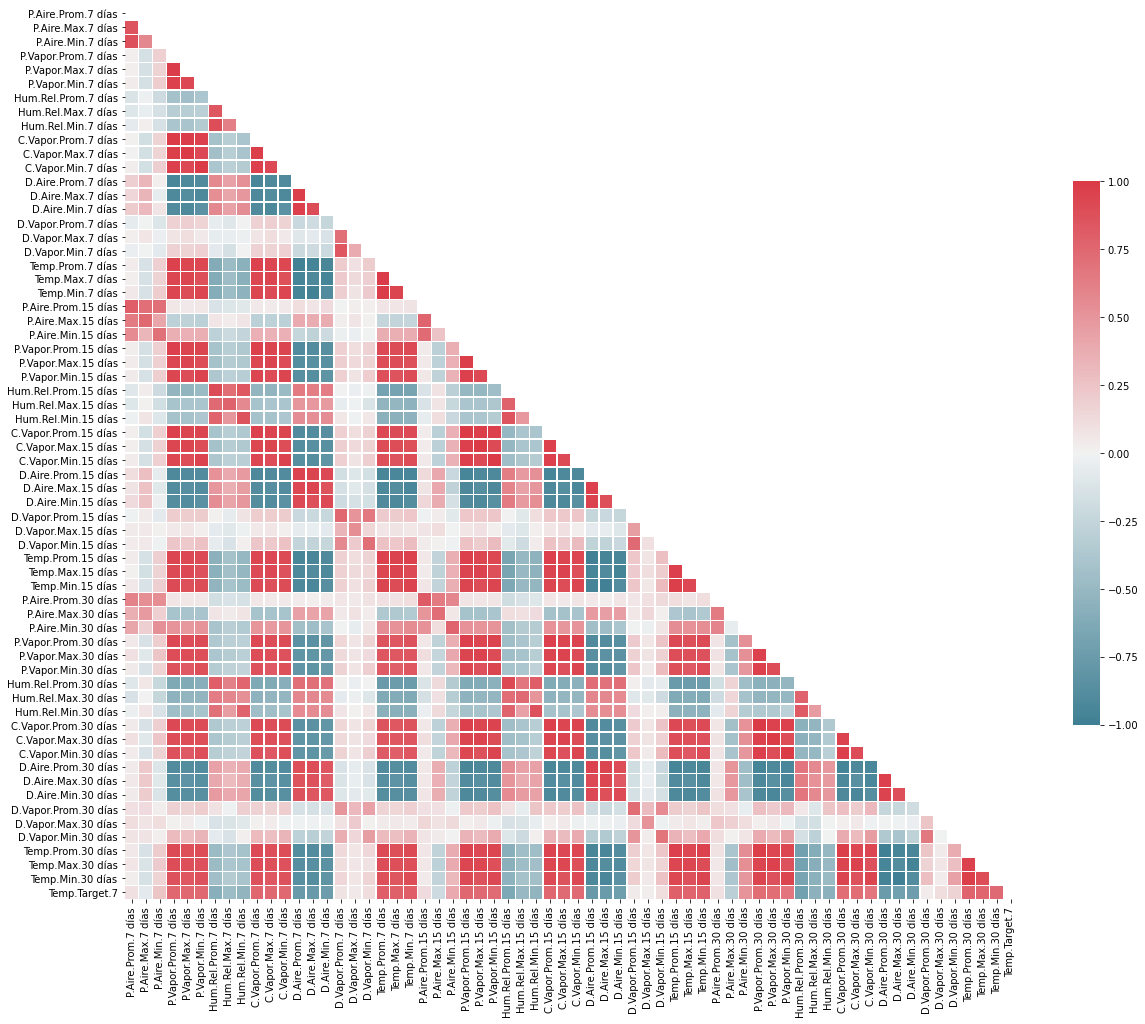

In [100]:
# Mecanismo para graficar obtenido de los talleres de la clase.

f, ax = plt.subplots(figsize=(20, 20))
# Mapa de colores
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Borramos la parte diagonal superior con una máscara
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0, mask=mask, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Como el DataSet fue construido a través de la construccion de caracteristicas usando máximos, minimos y promedios se pueden observar bloques de correlación.

"scikit-learn no ofrece el cálculo del R2 ajustado (viva Python!), por lo que lo calculamos a mano" (Diaz, Javier, 2020)

In [103]:
def r2adj(y_real, y_pred, numFeatures):
    return 1 - (1-r2_score(y_real, y_pred))*(len(y_real)-1) / (len(y_real) - numFeatures - 1)

In [106]:
regr = LinearRegression( normalize=True )
regr.fit(X_train, y_train)

LinearRegression(normalize=True)

In [109]:
# indep_vars = df1.columns # en el taller se usa el dataframe completo, ¿eso no está mal?
indep_vars = X_train.columns # 

for var, coef in zip(indep_vars, np.squeeze(regr.coef_)):
    print("{}: {}".format(var, coef))
print("intercepción: {}".format(np.squeeze(regr.intercept_)))

P.Aire.Prom.7 días: 1.3956178219248896
P.Aire.Max.7 días: 0.15994648437745423
P.Aire.Min.7 días: 0.18701947412380418
P.Vapor.Prom.7 días: -32.954860136473954
P.Vapor.Max.7 días: 1.47943808341468
P.Vapor.Min.7 días: 0.4397379427862212
Hum.Rel.Prom.7 días: -0.02306480845801582
Hum.Rel.Max.7 días: -0.0579690453357993
Hum.Rel.Min.7 días: -0.020023542766371152
C.Vapor.Prom.7 días: 31.84672492594877
C.Vapor.Max.7 días: -1.7964326973818219
C.Vapor.Min.7 días: -0.10000290560295985
D.Aire.Prom.7 días: -1.0100985653840404
D.Aire.Max.7 días: -0.08244695939672558
D.Aire.Min.7 días: -0.11203653373493962
D.Vapor.Prom.7 días: -0.02504557266107732
D.Vapor.Max.7 días: 0.011638150326144169
D.Vapor.Min.7 días: 0.01806131824717656
Temp.Prom.7 días: -4.432033761031173
Temp.Max.7 días: -0.017645177016782913
Temp.Min.7 días: -0.2991819034658288
P.Aire.Prom.15 días: -3.3409884929620106
P.Aire.Max.15 días: -0.13178388263748267
P.Aire.Min.15 días: -0.11924292931213405
P.Vapor.Prom.15 días: 78.46464604196518
P.V

In [112]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso #modelamiento
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import KFold, cross_val_score #protocolo de evaluación
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score #métricas de evaluación
from sklearn.preprocessing import scale 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

train_y_pred = regr.predict(X_train)
test_y_pred = regr.predict(X_test)
print(train_y_pred.shape)
print(test_y_pred.shape)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))


(1510,)
(648,)
MSE (train): 14.9404
MSE (test) : 24.4578
R2  (train): 0.7636
R2  (test) : 0.4720
R2 adj (train): 0.7533
R2 adj (test): 0.4151


Regresión linear normalizada, línea base con todas las variables independientes.

Métricas 

MSE (train): 14.9404

MSE (test) : 24.4578

R2  (train): 0.7636

R2  (test) : 0.4720

R2 adj (train): 0.7533

R2 adj (test): 0.4151

In [115]:
train_x2 = sm.add_constant(X_train.values)
modeloStats = sm.OLS(np.asarray(y_train), train_x2)
results = modeloStats.fit()
#Consultamos la calidad del modelo a partir de sus estadísticas
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     74.15
Date:                Fri, 13 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:51:13   Log-Likelihood:                -4184.2
No. Observations:                1510   AIC:                             8496.
Df Residuals:                    1446   BIC:                             8837.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -417.0976     84.286     -4.949      0.000    -582.433    -251.762
x1             1.3956      0.554      2.518      0.012       0.308       2.483
x2             0.1599      0.055      2.924      0.004       0.053       0.267
x3             0.1870      0.048      3.905      0.000       0.093       0.281
x4           -32.9549     12.471     -2.642      0.008     -57.419      -8.491
x5             1.4794      2.816      0.525      0.599      -4.043       7.002
x6             0.4397      3.792      0.116      0.908      -6.998       7.878
x7            -0.0231      0.096     -0.240      0.811      -0.212       0.166
x8            -0.0580      0.034     -1.693      0.091      -0.125       0.009
x9            -0.0200      0.035     -0.565      0.572      -0.090       0.050
x10           31.8467     12.346      2.579      0.010       7.628      56.065
x11           -1.7964      2.768     -0.649      0.516      -7.225       3.632
x12           -0.1000      3.753     -0.027      0.979      -7.461       7.261
x13           -1.0101      0.403     -2.506      0.012      -1.801      -0.220
x14           -0.0824      0.032     -2.611      0.009      -0.144      -0.020
x15           -0.1120      0.030     -3.733      0.000      -0.171      -0.053
x16           -0.0250      0.010     -2.569      0.010      -0.044      -0.006
x17            0.0116      0.007      1.775      0.076      -0.001       0.024
x18            0.0181      0.005      3.624      0.000       0.008       0.028
x19           -4.4320      2.007     -2.208      0.027      -8.369      -0.495
x20           -0.0176      0.162     -0.109      0.913      -0.334       0.299
x21           -0.2992      0.166     -1.797      0.073      -0.626       0.027
x22           -3.3410      0.930     -3.592      0.000      -5.166      -1.516
x23           -0.1318      0.057     -2.308      0.021      -0.244      -0.020
x24           -0.1192      0.045     -2.634      0.009      -0.208      -0.030
x25           78.4646     19.767      3.969      0.000      39.690     117.240
x26           -9.7086      2.410     -4.029      0.000     -14.436      -4.982
x27            1.4813      3.978      0.372      0.710      -6.323       9.285
x28            0.2416      0.143      1.685      0.092      -0.040       0.523
x29           -0.0455      0.039     -1.153      0.249      -0.123       0.032
x30           -0.0111      0.038     -0.291      0.771      -0.086       0.064
x31          -77.6291     19.574     -3.966      0.000    -116.026     -39.232
x32            9.9055      2.371      4.178      0.000       5.255      14.556
x33           -0.7762      3.923     -0.198      0.843      -8.472       6.919
x34            2.4681      0.682      3.617      0.000       1.130       3.807
x35            0.0634      0.029      2.218      0.027       0.007       0.120
x3

El análisis estadístico muestra fuerte multicolinealidad, lo cual era predecible por la forma de construcción de del DataSet.

### Para el siguiente tramo, se realiza una revisión de la correlación con la variables objetivo: "Temp.Target.7"

In [200]:
correlacionesSalario = corr['Temp.Target.7']
print(correlacionesSalario)

P.Aire.Prom.7 días     0.100419
P.Aire.Max.7 días     -0.074197
P.Aire.Min.7 días      0.245585
P.Vapor.Prom.7 días    0.757326
P.Vapor.Max.7 días     0.745066
                         ...   
D.Vapor.Min.30 días    0.164375
Temp.Prom.30 días      0.769785
Temp.Max.30 días       0.759702
Temp.Min.30 días       0.739801
Temp.Target.7          1.000000
Name: Temp.Target.7, Length: 64, dtype: float64


Se observan las variables de mayor correlación, se seleccionan: 

- Temperatura promedio 30 días y la Densidad de aire 7 días.

In [201]:
train_x_red = X_train[['Temp.Prom.30 días', 'D.Aire.Max.7 días']]
test_x_red = X_test[['Temp.Prom.30 días', 'D.Aire.Max.7 días']]
regr_red = LinearRegression(normalize=True)
regr_red.fit(train_x_red, y_train)

LinearRegression(normalize=True)

In [202]:
train_y_pred = regr_red.predict(train_x_red)
test_y_pred = regr_red.predict(test_x_red)
print(train_y_pred.shape)
print(test_y_pred.shape)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

(1510,)
(648,)
MSE (train): 23.7738
MSE (test) : 19.1685
R2  (train): 0.6239
R2  (test) : 0.5862
R2 adj (train): 0.6075
R2 adj (test): 0.5416


Regresión linear normalizada, línea base con todas las variables independientes.

Métricas
 
(PREVIO)
R2 adj (train): 0.7533
R2 adj (test): 0.4151

----------------------------
(ACTUAL)
R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

In [203]:
train_x2 = sm.add_constant(train_x_red.values)
modeloStats = sm.OLS(np.asarray(y_train), train_x2)
results = modeloStats.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1250.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):          1.05e-320
Time:                        13:12:42   Log-Likelihood:                -4534.9
No. Observations:                1510   AIC:                             9076.
Df Residuals:                    1507   BIC:                             9092.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.9165      9.065     11.353      0.000      85.135     120.698
x1             0.4792      0.038     12.634      0.000       0.405       0.554
x2            -0.0793      0.007    -11.197      0.000      -0.093      -0.065
==============================================================================
Omnibus:                       14.592   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.232
Skew:                          -0.098   Prob(JB):                     4.04e-05
Kurtosis:                       3.532   Cond. No.                     8.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El análisis estadístico muestra fuerte multicolinealidad, lo cual era predecible por la forma de construcción de del DataSet.

## Modelos usando: Ridge regression

Se realiza el cálculo de alphas en espacio logarítmico.

In [204]:
metrica = 'r2' #'neg_mean_squared_error'
n_alphas = 200
alphas = np.logspace(-6, 2, n_alphas)
alphas[:5]

array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06])

(C1) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Ridge (L2) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Ridge usando los alphas previamente claculados.

In [231]:
steps = [('STD', StandardScaler()), ("RidgeReg", Ridge(fit_intercept=True, normalize=False))]
pipeline = Pipeline(steps)
parametros = {'RidgeReg__alpha':alphas}

grid1A = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
grid1A.fit(X_train, y_train)
print(grid1A.best_params_)

train_y_pred = grid1A.best_estimator_.predict(X_train)
test_y_pred = grid1A.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = grid1A.score(X_train, y_train)
test_score_p = grid1A.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

{'RidgeReg__alpha': 0.01}
MSE (train): 15.2261
MSE (test) : 23.1803
R2  (train): 0.7591
R2  (test) : 0.4996
R2 adj (train): 0.7486
R2 adj (test): 0.4456
train:  0.759101225142536 test 0.49961109242501434




(PREVIO)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL)

R2 adj (train): 0.7486
R2 adj (test): 0.4456

(C2) Modelo con el siguiente pipeline:

- Sin Estandarización
- Regresión de Ridge (L2) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Ridge usando los alphas previamente claculados.

In [232]:
steps = [("RidgeReg", Ridge(fit_intercept=True, normalize=False))]
pipeline = Pipeline(steps)
parametros = {'RidgeReg__alpha':alphas}
grid2B = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
grid2B.fit(X_train, y_train)
print(grid2B.best_params_)

train_y_pred = grid2B.best_estimator_.predict(X_train)
test_y_pred = grid2B.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = grid2B.score(X_train, y_train)
test_score_p = grid2B.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

{'RidgeReg__alpha': 0.01}
MSE (train): 14.9962
MSE (test) : 23.8228
R2  (train): 0.7627
R2  (test) : 0.4857
R2 adj (train): 0.7524
R2 adj (test): 0.4303
train:  0.762738573492797 test 0.4857425697402188


(PREVIO MEJOR)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL)

R2 adj (train): 0.7524 R2 adj (test): 0.4303

(C3) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Ridge (L2) ajustado al intercepto con normalización.

Se monta sobre un grid de búsqueda con parámetros para Ridge usando los alphas previamente calculados.

In [233]:
steps = [('STD', StandardScaler()),("RidgeReg", Ridge(fit_intercept=True, normalize=True))]
pipeline = Pipeline(steps)
parametros = {'RidgeReg__alpha':alphas}

grid2C = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
grid2C.fit(X_train, y_train)
print(grid2C.best_params_)

train_y_pred = grid2C.best_estimator_.predict(X_train)
test_y_pred = grid2C.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = grid2C.score(X_train, y_train)
test_score_p = grid2C.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

{'RidgeReg__alpha': 0.01}
MSE (train): 16.2381
MSE (test) : 20.1078
R2  (train): 0.7431
R2  (test) : 0.5659
R2 adj (train): 0.7319
R2 adj (test): 0.5191
train:  0.7430896413441593 test 0.5659367903635505


(PREVIO MEJOR)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL)

R2 adj (train): 0.7319
R2 adj (test): 0.5191

Tras realizar 3 modelos basados en Ridge, se encontró que el mejor resultado basado en la métrica R2-adj, es el módelo (C1) con estandarización y Ridge no normalizado.

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor) 

In [246]:
stdmodel = StandardScaler()
train_x_std = stdmodel.fit_transform(X_train, np.ravel(y_train))
test_x_std = stdmodel.transform(X_test)

In [247]:
coefs = []
r2adj_train_vec = []
r2adj_test_vec = []

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True, normalize=True)
    ridge.fit(train_x_std, y_train)
    coefs.append(ridge.coef_)
    train_y_pred = ridge.predict(train_x_std)
    test_y_pred = ridge.predict(test_x_std)
    r2_aj_train = r2adj(y_train, train_y_pred, train_x_std.shape[1])
    r2_aj_test = r2adj(y_test, test_y_pred, test_x_std.shape[1])
    r2adj_train_vec.append(r2_aj_train)
    r2adj_test_vec.append(r2_aj_test)

In [249]:
plt.figure(figsize=(12,4))
ax = plt.gca() # get current axis
plt.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.title('Coeficientes de Ridge en función del parámetro de regularización')
plt.legend(indep_vars, loc="right")

SyntaxError: invalid syntax (<ipython-input-249-e3ac20e280dc>, line 10)

In [248]:
# buscamos las variables más importantes

t1 = np.array(r2adj_train_vec)
t1 = t1[:, np.newaxis]
print("train: ", t1.shape)

t2 = np.array(r2adj_test_vec)
t2 = t2[:, np.newaxis]
print("test: ", t2.shape)

r2adj_vecs = np.concatenate((t1, t2), axis=1)
print("concatenación: ", r2adj_vecs.shape)

train:  (200, 1)
test:  (200, 1)
concatenación:  (200, 2)


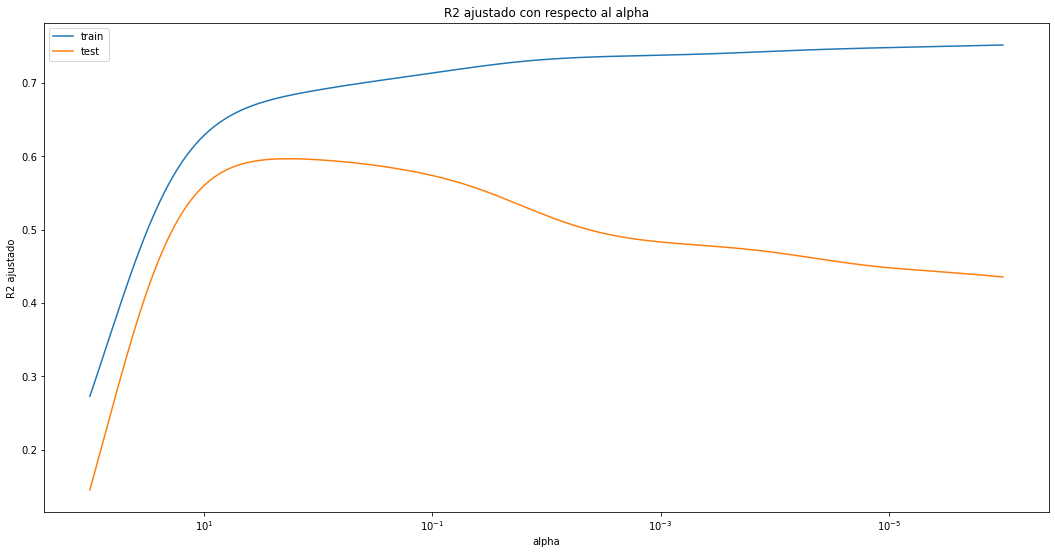

In [212]:
plt.figure(figsize=(18,9))
ax = plt.gca()
plt.plot(alphas, r2adj_vecs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('R2 ajustado')
plt.title('R2 ajustado con respecto al alpha')
plt.legend(['train', 'test'])

## Modelos usando: Lasso regression

In [250]:
# Se generan los Alphas 
n_alphas = 200
alphas = np.logspace(-2, 2, n_alphas)
alphas[:5]

array([0.01      , 0.01047371, 0.01096986, 0.01148951, 0.01203378])

(D1) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Lasso (L1) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Lasso usando los alphas previamente calculados.

In [260]:
steps = [('STD', StandardScaler()), ("LassoReg", Lasso(fit_intercept=True, normalize=False, max_iter=10000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'LassoReg__alpha':alphas}
gridD1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
gridD1.fit(X_train, y_train)
print(gridD1.best_params_)

train_y_pred = gridD1.best_estimator_.predict(X_train)
test_y_pred = gridD1.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = gridD1.score(X_train, y_train)
test_score_p = gridD1.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

{'LassoReg__alpha': 0.01}
MSE (train): 16.1501
MSE (test) : 20.4237
R2  (train): 0.7445
R2  (test) : 0.5591
R2 adj (train): 0.7333
R2 adj (test): 0.5116
train:  0.7444814192401571 test 0.5591169642880949


(PREVIO MEJOR - Ridge)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL - Lasso)

R2 adj (train): 0.7333
R2 adj (test): 0.5116

(D2) Modelo con el siguiente pipeline:

- No Estandarización
- Regresión de Lasso (L1) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Lasso usando los alphas previamente calculados.

In [261]:
steps = [("LassoReg", Lasso(fit_intercept=True, normalize=False, max_iter=15000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'LassoReg__alpha':alphas}
gridD2 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
gridD2.fit(X_train, y_train)
print(gridD2.best_params_)

train_y_pred = grid4D.best_estimator_.predict(X_train)
test_y_pred = grid4D.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = gridD2.score(X_train, y_train)
test_score_p = gridD2.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

{'LassoReg__alpha': 0.01}
MSE (train): 15.8491
MSE (test) : 21.5904
R2  (train): 0.7492
R2  (test) : 0.5339
R2 adj (train): 0.7383
R2 adj (test): 0.4837
train:  0.7492433307836938 test 0.5339318965004785


(PREVIO MEJOR - Ridge)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL - Lasso)

R2 adj (train): 0.7383
R2 adj (test): 0.4837

(D3) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Lasso (L1) ajustado al intercepto con normalización.

Se monta sobre un grid de búsqueda con parámetros para Lasso usando los alphas previamente calculados.

In [262]:
steps = [('STD', StandardScaler()), ("LassoReg", Lasso(fit_intercept=True, normalize=True, max_iter=10000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'LassoReg__alpha':alphas}
gridD3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
gridD3.fit(X_train, y_train)
print(gridD3.best_params_)

train_y_pred = gridD3.best_estimator_.predict(X_train)
test_y_pred = gridD3.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = gridD3.score(X_train, y_train)
test_score_p = gridD3.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

{'LassoReg__alpha': 0.01}
MSE (train): 19.2565
MSE (test) : 17.1033
R2  (train): 0.6953
R2  (test) : 0.6308
R2 adj (train): 0.6821
R2 adj (test): 0.5910
train:  0.6953333096071757 test 0.6307954499469437


(PREVIO MEJOR - Ridge)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 

---------------------------------------------------------

(ACTUAL - Lasso)

R2 adj (train): 0.6821
R2 adj (test): 0.5910 (Mejor)

Tras analizar usando la regresión Lasso, se encontróo que el modelo más preciso fue el (D3) con la estructura: Estandarización, Lasso con normalización.

In [255]:
stdmodel = StandardScaler()
train_x_std = stdmodel.fit_transform(X_train, np.ravel(y_train))
test_x_std = stdmodel.transform(X_test)

In [256]:
coefs = []
r2adj_train_vec = []
r2adj_test_vec = []

for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=True, normalize=True, max_iter=10000, tol=0.01)
    lasso.fit(train_x_std, y_train)
    coefs.append(lasso.coef_)
    train_y_pred = lasso.predict(train_x_std)
    test_y_pred = lasso.predict(test_x_std)
    r2_aj_train = r2adj(y_train, train_y_pred, train_x_std.shape[1])
    r2_aj_test = r2adj(y_test, test_y_pred, test_x_std.shape[1])
    r2adj_train_vec.append(r2_aj_train)
    r2adj_test_vec.append(r2_aj_test)

In [ ]:
plt.figure(figsize=(15,7))
ax = plt.gca() # get current axis
plt.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.title('Coeficientes de Ridge en función del parámetro de regularización')
plt.legend(indep_vars, loc="right")

In [ ]:
t1 = np.array(r2adj_train_vec)
t1 = t1[:, np.newaxis]
print("train: ", t1.shape)

t2 = np.array(r2adj_test_vec)
t2 = t2[:, np.newaxis]
print("test: ", t2.shape)

r2adj_vecs = np.concatenate((t1, t2), axis=1)
print("concatenación: ", r2adj_vecs.shape)

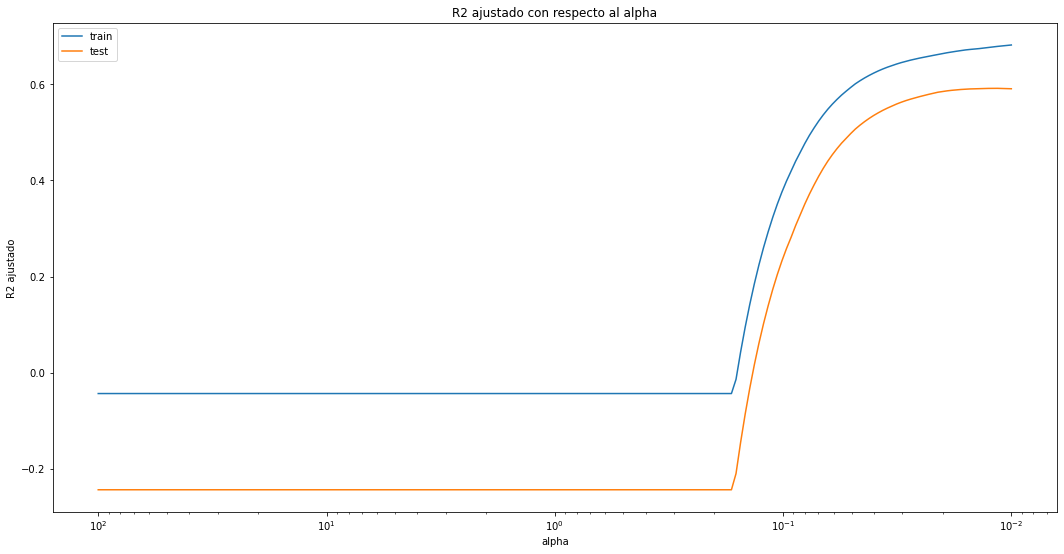

In [222]:
plt.figure(figsize=(18,9))
ax = plt.gca()
plt.plot(alphas, r2adj_vecs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('R2 ajustado')
plt.title('R2 ajustado con respecto al alpha')
plt.legend(['train', 'test'])

## Redes Neuronales

Considere los datos como una serie tiempo multivariada y utilice modelos de redes neuronales convolucionales para poder predecir la temperatura del séptimo día siguiente:

- Considere los datos como series de tiempo (no utilice modelos de forecasting como Arima o Holt-Winters, solo redes convolucionales). Debe buscar la mejor ventana de datos que le permita la mejor predicción
- Los datos deben ser transformados entonces en tensores de rango 3: (batch, ventana de tiempo, número de variables a predecir)
- Utilice filtros convolucionales de 1D. Defina una arquitectura con varias convolucionales 1D. Por ejemplo para ventanas de 60 días, se pueden definir en una primera capa 32 kernels de tamaño 3, 5, 7 días.
- Evalúe la utilidad del dropout para regularizar antes de la o las capas densas, intente varios valores.
- Evalúe la utilidad regularizar los kernels de las capas convolucionales con L1 o/y L2, intente varios valores.